In [1]:
import pandas as pd
from PIL import Image
import requests
from neo4j import GraphDatabase
import random
%matplotlib inline

### LOAD THE DATA

In [2]:
data = pd.read_csv('data/data_dist.csv', index_col=0)
data

name  \
0            giuseppe-arcimboldo_portrait-of-eve-1578.jpg   
1           giuseppe-arcimboldo_portrait-of-adam-1578.jpg   
2              giuseppe-arcimboldo_the-vegetable-bowl.jpg   
3       giuseppe-arcimboldo_vertumnus-emperor-rudolph-...   
4                   giuseppe-arcimboldo_self-portrait.jpg   
...                                                   ...   
116470             ismail-shammout_self-portrait-1955.jpg   
116471  ismail-shammout_nahnou-bi-kheyr-taminouna-we-a...   
116472  ismail-shammout_odyssey-of-a-people-detail-198...   
116473  ismail-shammout_untitled-from-the-tall-al-zaat...   
116474                         rita-angus_growth-1968.jpg   

                                                   prompt  \
0       "Portrait of Eve", painted by Giuseppe Arcimbo...   
1       "Portrait of Adam", painted by Giuseppe Arcimb...   
2       "The Vegetable Gardener", painted by Giuseppe ...   
3       "Vertumnus (Emperor Rudolph II)", painted by G...   
4       "Self-Portrait", painted by Giuseppe Arcimbold...   
...                                                   ...   
116470  "Self Portrait", painted by Ismail Shammout.\r...   
116471  "Nahnou Bi Kheyr, Taminouna (We Are in Good He...   
116472  "Odyssey of a People (detail)", painted by Ism...   
116473  "Untitled (from the Tall Al Zaatar Series)", p...   
116474  "Growth", painted by Rita Angus.\r\nIt has bee...   

                                                  caption       itm       itc  
0       The "Portrait of Eve", painted by Giuseppe Arc...  0.482981  0.494498  
1       The "Portrait of Adam", painted by Giuseppe Ar...  0.741062  0.467100  
2       "The Vegetable Gardener" is a still life, pain...  0.051702  0.433112  
3       The painting is hosted in Skokloster Castle, H...  0.556686  0.399439  
4       The "Self-Portrait", painted by Giuseppe Arcim...  0.416339  0.404134  
...                                                   ...       ...       ...  
116470  "Self Portrait" is a selfportrait of Ismail Sh...  0.994248  0.474817  
116471  "We Are in Good Health, Reassure Us, Nahnou Bi...  0.981330  0.461453  
116472  "Odyssey of a People" is a symbolic painting b...  0.991088  0.463176  
116473  is a symbolic painting in the style of magic r...  0.261516  0.363797  
116474  "Growth", painted by Rita Angus in 1968, is an...  0.334592  0.401931  

[116475 rows x 5 columns]

#### LET'S SEE THE SEMANTIC MATCHING...

<Axes: ylabel='Density'>

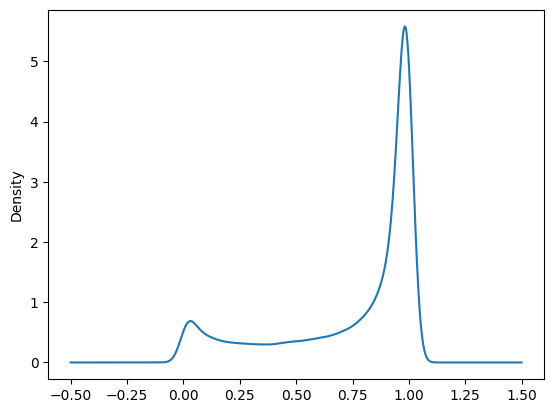

In [3]:
data.itm.plot.density()

#### ...AND THE GEOMETRIC MATCHING

<Axes: ylabel='Density'>

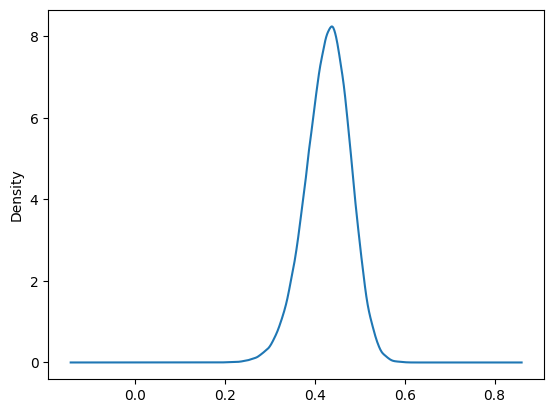

In [4]:
data.itc.plot.density()

It could be that the semantic matching could be not aligned due to some feature (e.g. style).
In fact a **abstract** painting is not so easy to match with a textual description

In [5]:
driver = GraphDatabase.driver(uri = "bolt://localhost:7687", auth = ('neo4j','neo4j'))

Get the base distribution

In [6]:
with driver.session(database='neo4j') as session:
    query_style = 'match (a: Artwork)--(s: Style) return s.name as style, count(distinct a) as num_artworks'
    query_genre = 'match (a: Artwork)--(g: Genre) return g.name as genre, count(distinct a) as num_artworks'
    query_combined = '''match (a:Artwork)
                        match (a)--(s:Style)
                        match (a)--(g:Genre)
                        return s.name as style, g.name as genre, count(distinct a) as num_artworks'''
    ans_style = list(map(tuple, iter(session.run(query_style))))
    ans_genre = list(map(tuple, iter(session.run(query_genre))))
    ans_combined = list(map(tuple, iter(session.run(query_combined))))
style = {k: v for k, v in ans_style}
genre = {k: v for k, v in ans_genre}
combined = {f'{s}_{g}': v for s, g, v in ans_combined}

In [7]:
unmatched = data[data.itm <= .1].name.tolist()
unmatched[:10]

['giuseppe-arcimboldo_the-vegetable-bowl.jpg',
 'frida-kahlo_portrait-of-frida-s-family-1954.jpg',
 'frida-kahlo_self-portrait-with-cropped-hair-1940.jpg',
 'frida-kahlo_the-bride-frightened-at-seeing-life-opened-1943.jpg',
 'giorgione_two-women-and-a-man-trio-1510.jpg',
 'giorgione_nude-young-woman-1508.jpg',
 'giorgione_musical-instruments-music-1510.jpg',
 'giorgione_armor-1510.jpg',
 'jacopo-bellini_tomb-of-a-prince.jpg',
 'jacopo-bellini_not-detected-2.jpg']

In [8]:
with driver.session(database='neo4j') as session:
    query = f'''match (a:Artwork) where a.name in {unmatched}
                match (a)--(s:Style)
                return s.name as style, count(distinct a) as num_artworks'''
    ans_style = list(map(tuple, iter(session.run(query))))
perc_unmatched_style = {k: v/style[k] for k, v in ans_style}

In [9]:
with driver.session(database='neo4j') as session:
    query = f'''match (a:Artwork) where a.name in {unmatched}
                match (a)--(g:Genre)
                return g.name as genre, count(distinct a) as num_artworks'''
    ans_genre = list(map(tuple, iter(session.run(query))))
perc_unmatched_genre = {k: v/genre[k] for k, v in ans_genre}

In [10]:
with driver.session(database='neo4j') as session:
    query = f'''match (a:Artwork) where a.name in {unmatched}
                match (a)--(s:Style)
                match (a)--(g:Genre)
                return s.name as style, g.name as genre, count(distinct a) as num_artworks'''
    ans_combined = list(map(tuple, iter(session.run(query))))
perc_unmatched_combined = {f'{s}_{g}': v for s, g, v in ans_combined}
#perc_unmatched_combined = {f'{s}_{g}': v/combined[f'{s}_{g}'] for s, g, v in ans_combined}

# Now let's see the results

### STYLE

In [11]:
inverse_items = list(map(tuple, perc_unmatched_style.items()))
items = list(map(lambda x: (x[1], x[0]), inverse_items))
sorted(items, reverse=True)[:10]

[(0.18571428571428572, 'neo-romanticism'),
 (0.16835541699142634, 'neo-expressionism'),
 (0.15796519410977242, 'pop art'),
 (0.14141589841711602, 'art nouveau (modern)'),
 (0.12462462462462462, 'color field painting'),
 (0.12417340191036003, 'surrealism'),
 (0.12256493506493507, 'minimalism'),
 (0.10505836575875487, 'abstract expressionism'),
 (0.1022530329289428, 'art informel'),
 (0.10118306351183064, 'neoclassicism')]

### GENRE

In [12]:
inverse_items = list(map(tuple, perc_unmatched_genre.items()))
items = list(map(lambda x: (x[1], x[0]), inverse_items))
sorted(items, reverse=True)[:10]

[(0.18939554612937434, 'illustration'),
 (0.18273337400854178, 'figurative'),
 (0.1305732484076433, 'symbolic painting'),
 (0.12276867030965391, 'design'),
 (0.0996316758747698, 'sketch and study'),
 (0.09433962264150944, 'self-portrait'),
 (0.09272727272727273, 'abstract'),
 (0.07762134123749537, 'genre painting'),
 (0.07042253521126761, 'animal painting'),
 (0.06834030683403068, 'religious painting')]

### COMBINED


In [13]:
inverse_items = list(map(tuple, perc_unmatched_combined.items()))
items = list(map(lambda x: (x[1], x[0]), inverse_items))
sorted(items, reverse=True)[:10]

[(312, 'abstract expressionism_abstract'),
 (310, 'art nouveau (modern)_illustration'),
 (257, 'surrealism_symbolic painting'),
 (255, 'romanticism_portrait'),
 (218, 'expressionism_genre painting'),
 (209, 'realism_genre painting'),
 (189, 'expressionism_portrait'),
 (185, 'romanticism_illustration'),
 (182, 'realism_portrait'),
 (174, 'impressionism_genre painting')]

The combination of genre-style illustrates the real nature of outliers.
Let's see an example of each combination

In [15]:
#combinations = list(map(lambda x: x[1].split('_'), filter(lambda x: x[0] == 1.0, items)))
combinations = list(map(lambda x: x[1].split('_'), sorted(items, reverse=True)[:5]))
combinations

[['abstract expressionism', 'abstract'],
 ['art nouveau (modern)', 'illustration'],
 ['surrealism', 'symbolic painting'],
 ['romanticism', 'portrait'],
 ['expressionism', 'genre painting']]

semantic mismatch of abstract expressionism + abstract
Displaying Medeic Callisthetic Moves V
Caption: "Medeic" is a painting by Geta Bratescu regarding "Callisthetic Moves V", which was done in 1981. It is a abstract in the style of abstract expressionism. It has been done in the same style as "The Line and Sketch" and "Sketch". It is one of the most important works in the collection of the Museum of Modern Art in Bucharest.


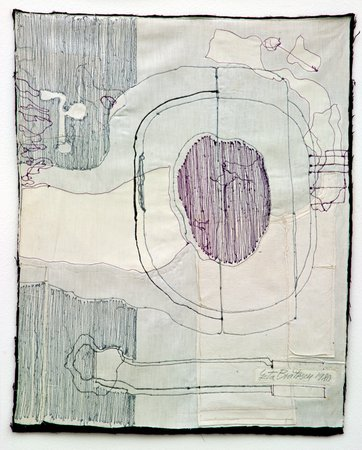

semantic mismatch of art nouveau (modern) + illustration
Displaying The Broom was on Fire at Once
Caption: "The Broom was on Fire at Once", painted by Virginia, is an illustration in the style of art nouveau or modern, belonging to the serie "Old French Fairy Tales" by Frances Sterrett. It has been done in 1920. It is one of the best known illustrations of the series. It was published in the first volume of the collection "Fairy Tales of France" in 1920, and in the second volume of "Old and New" in 1921.


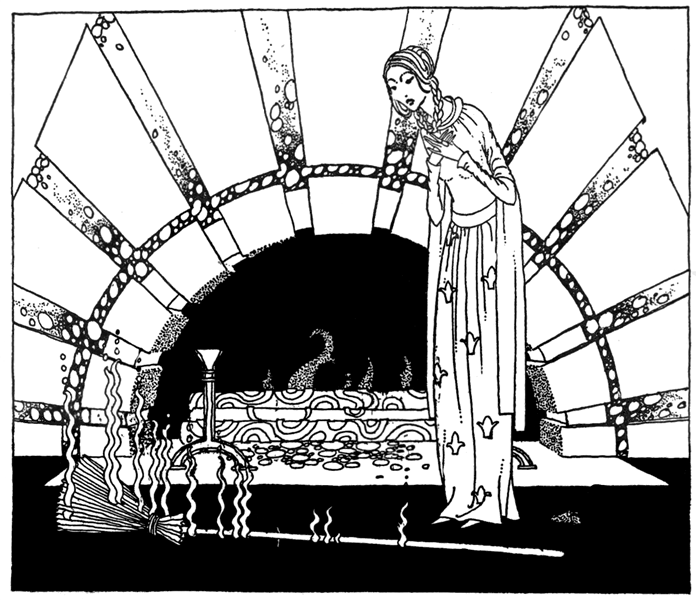

semantic mismatch of surrealism + symbolic painting
Displaying Crystal amoureux
Caption: "Crystal amoureux" is a symbolic painting by Jacques Hérold, painted by him in 1934. It has been done in the style of surrealism. It is one of the most important works of his, and is considered to be one of his best known works. It depicts the theme of "Organism" in the form of a crystal. It was one of a series of works that he painted regarding Organism. He also painted a number of works in this style, such as "The Sun and the Moon" and "The Moon".


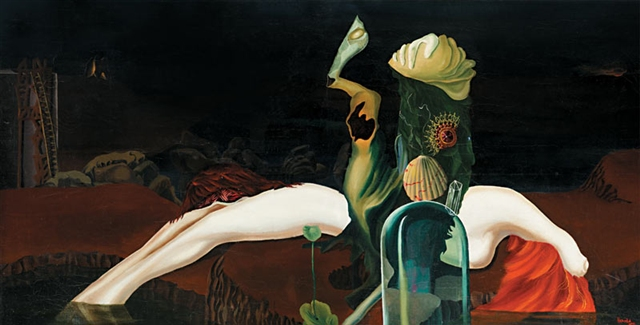

semantic mismatch of romanticism + portrait
Displaying Edward James Roye
Caption: The Gentleman. "Edward James Roye", painted by Thomas Sully, is a portrait in the style of romanticism. It is one of the earliest known portraits of a gentleman. It was painted by Sully in the late 18th century. It shows a young man with a young wife and a young child. The portrait is in the form of a portrait of a young woman. The subject of the portrait is unknown.


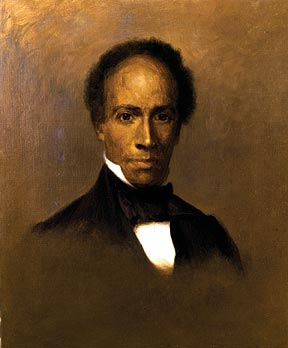

semantic mismatch of expressionism + genre painting
Displaying A Sleeping Passenger
Caption: "A Sleeping Passenger" is a genre painting by Werner Berg, painted by him in 1968. It has been done in the style of expressionism. The subject of the painting is the head of a woman with a sleeping child. The head is covered with a blanket and the child is sleeping on the floor. In the background of the image is the image of a man with his head on the ground and his hands on his knees. The man has his back to the viewer and his face is turned towards the viewer, as if he is looking at the viewer through the eyes of the child. There is also an image of the man with the head on his shoulders and his arms around


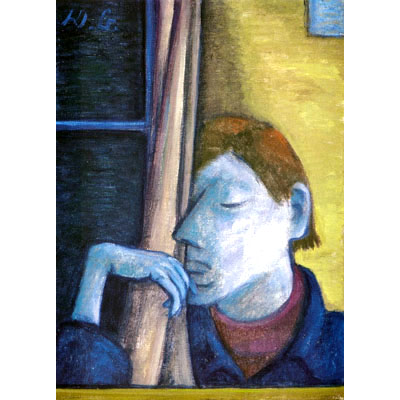

In [20]:
for [s, g] in combinations:
    print(f'semantic mismatch of {s} + {g}')
    with driver.session(database='neo4j') as session:
        query = f"""match (:Style{{name: '{s}'}})--(a:Artwork)--(: Genre{{name: '{g}'}})
        return a.image_url as url, a.title as title, a.name as name"""
        ans = random.choice(list(map(tuple, iter(session.run(query)))))
    print(f'Displaying {ans[1]}')
    print(f'Caption: {data[data.name == ans[2]].caption.values[0]}')
    raw_image = Image.open(requests.get(ans[0], stream=True).raw).convert('RGB')
    display(raw_image)

In [24]:
bests = data[data.itm > .9].sample(n=5).name.tolist()

Displaying Self Portrait with a Friend
Caption: The "Self Portrait with a Friend" is a 1518 painting by Raphael on oil and canvas regarding the life of a Gentleman. It is a selfportrait in the style of high renaissance. It has been done in 1518. The painting is hosted in the Louvre, Paris, France.


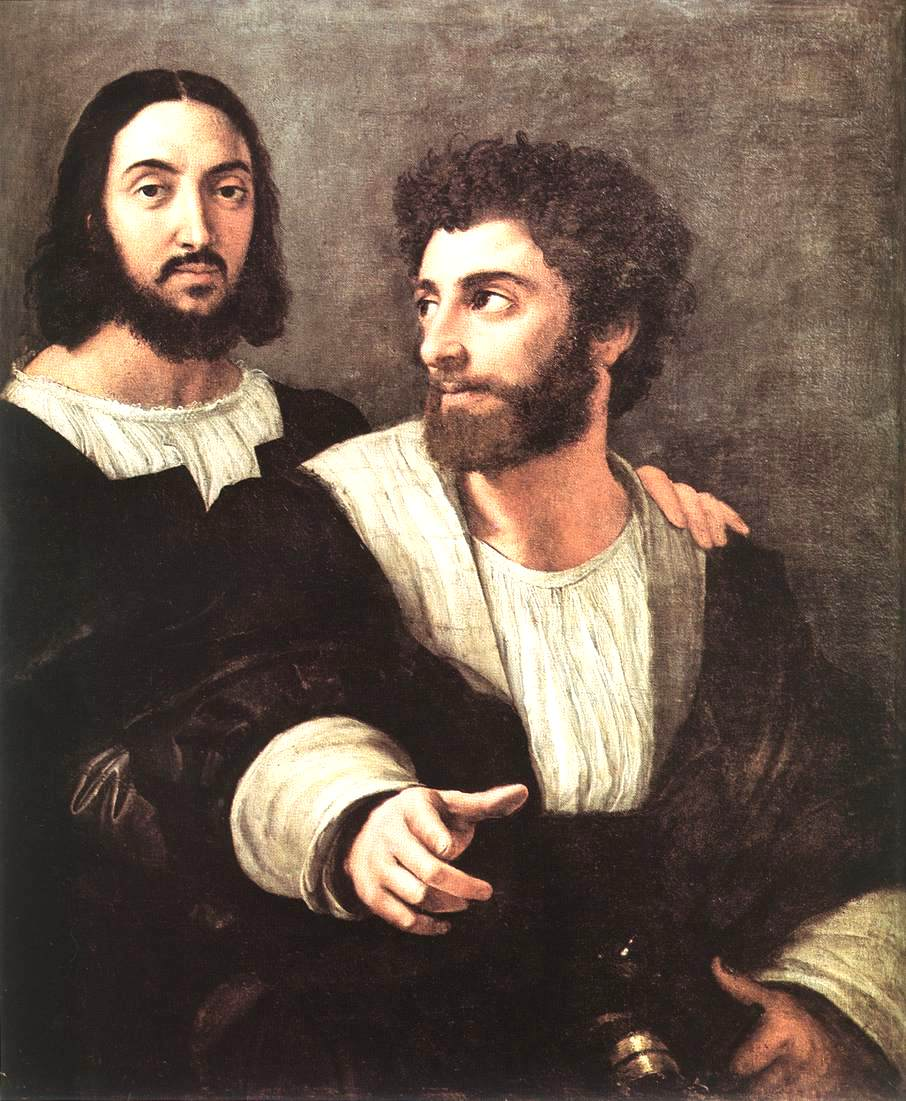

Displaying Arletty
Caption: "Arletty", painted by Kees van Dongen in 1931, is a portrait in the style of expressionism. It has been done in three parts, regarding Chin, Lady, Head and Cheek. It is one of the best known portraits of the artist. It was painted in the same style as the other works of the same artist. The subject of the portrait is the artist's wife.


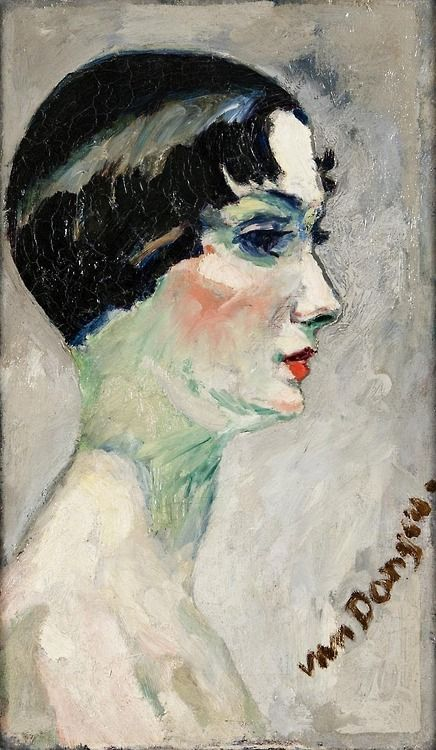

Displaying In the Woods near Bernried
Caption: "In the Woods near Bernried", painted by Lovis Corinth, is a landscape in the style of impressionism. It has been done in 1892, and is one of the best known examples of this genre. The subject matter of the painting is "Leaf, Nature, Vegetation, Natural landscape, Tree, Forest, Natural environment, sunlight and Jungle. It is a mixture of landscapes, still lifes and still lifes of the natural world.


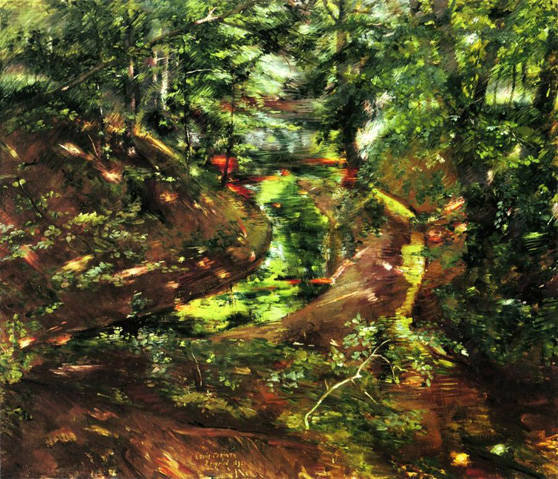

Displaying Forest Arabesque
Caption:  "Forest Arabesque", painted by Eyvind Earle, is a landscape in the style of magic realism, regarding forests and trees. It has been done in 1995 ; ;  It is one of the best known works of this genre. It is a collection of landscapes, which are divided into nine sections: Forest, Sky, Organism, Plant, Branch, Woody plant, Tree, Wood, Woodland, Forest and Tree.  It was published in the United States in 1999.


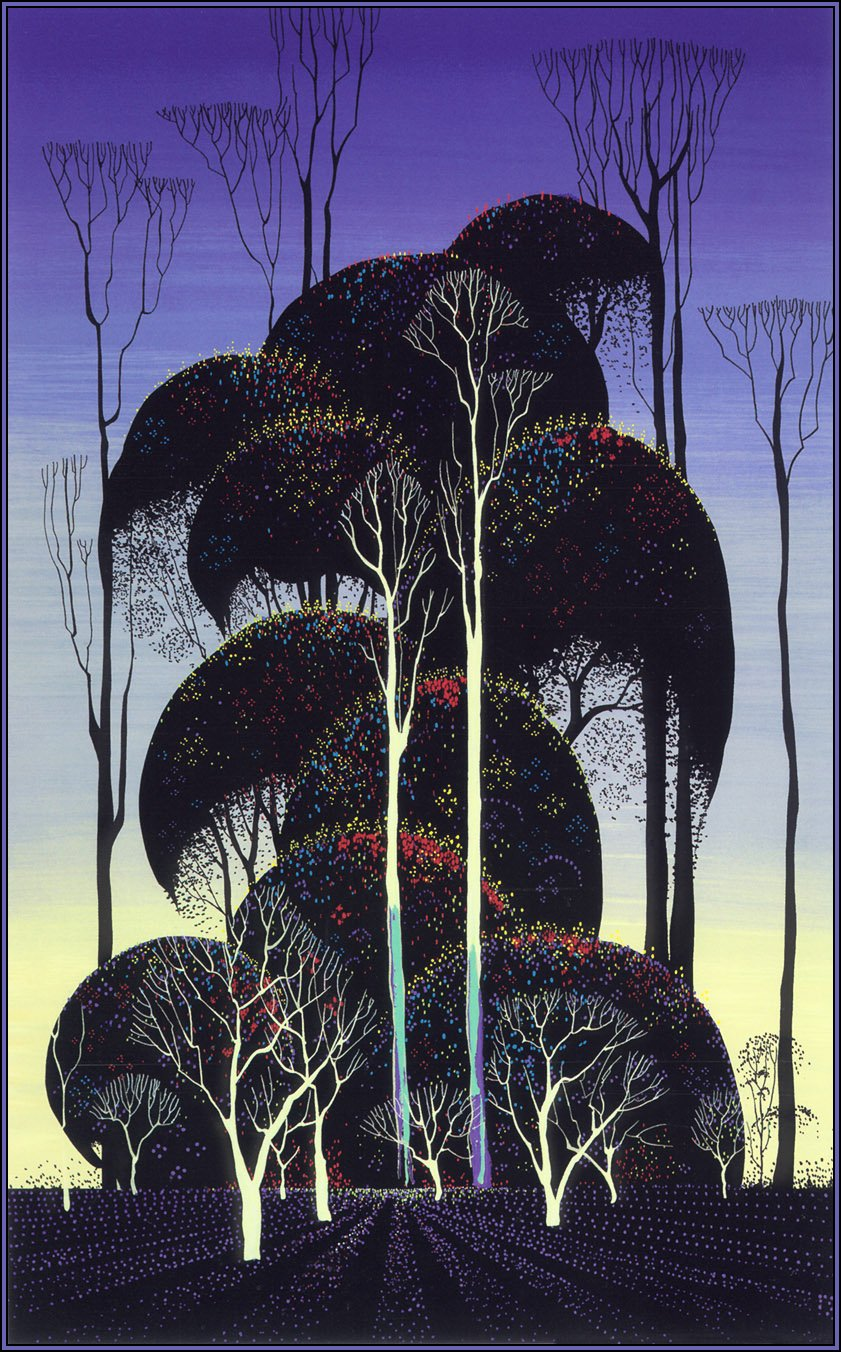

Displaying La Rochelle Quarry near the Port Entrance
Caption: The Ruins of La Rochelle is a painting by Camille Corot on canvas and oil on canvas, done in 1851. It is a cityscape in the style of realism, depicting the ruins of the old town of Rochelle and the Quarry near the Port Entrance. It has been done in oils and watercolors, and is one of the best known examples of Corot's work regarding houses, buildings and ruins. It shows the cityscape of the 17th and 18th centuries.


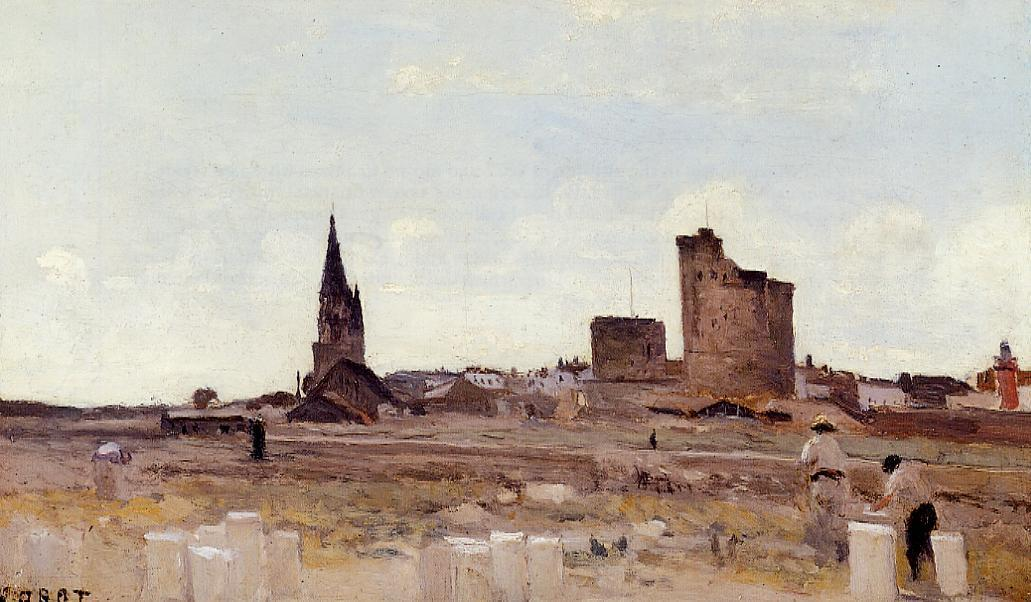

In [25]:
for name in bests:
    with driver.session(database='neo4j') as session:
        query = f"""match (a:Artwork{{name: '{name}'}})
        return a.image_url as url, a.title as title, a.name as name"""
        ans = list(map(tuple, iter(session.run(query))))[0]
    print(f'Displaying {ans[1]}')
    print(f'Caption: {data[data.name == ans[2]].caption.values[0]}')
    raw_image = Image.open(requests.get(ans[0], stream=True).raw).convert('RGB')
    display(raw_image)